# 自動微分について

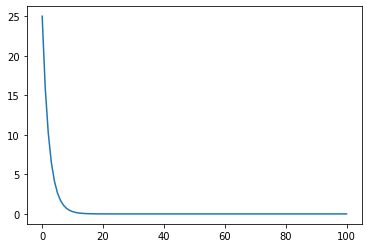

In [48]:
import numpy as np
import torch
#device = torch.device('cuda:0')
#device = torch.device('cpu')
# a = torch.tensor([2,4,3], dtype= torch.int32, device = device)
a = torch.tensor([3,4], dtype= torch.float32 , requires_grad=True) # 勾配情報をつける

y = torch.norm(a)**2
y.backward()

l = []
l.append(float(y))


alpha = 0.1
for i in range(100):
  a = a - alpha * a.grad
  a.retain_grad() # 中間変数には勾配が保存されないので、retain_gradする必要があり
  # a.grad == None なのでa.grad.zero_()しなくてよい
  y = torch.norm(a)**2
  y.backward()
  # a.grad != None
  l.append(float(y))

from matplotlib import pyplot as plt
plt.plot(l);

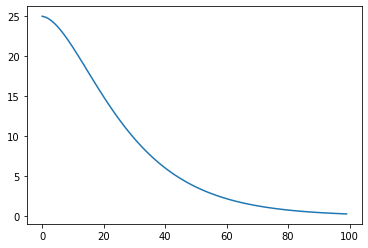

In [56]:
import numpy as np
import torch
import torch.optim as optim

a = torch.tensor([3,4], dtype= torch.float32 , requires_grad=True)
optimizer = optim.SGD([a], lr=0.001, momentum=0.9)

l = []

for i in range(100):
  optimizer.zero_grad()
  y = torch.norm(a)**2
  y.backward()
  l.append(float(y))
  optimizer.step()


from matplotlib import pyplot as plt
plt.plot(l);

# データセットづくり
torchvisionは特にコンピュータービジョン系のライブラリーである

In [ ]:
import numpy as np
s = None

labels = []
datas = None

for line in open('/content/sample_data/mnist_test.csv', 'r'):
    a = list(map(int,line.split(',')))
    label = a[0]
    labels.append(label)
    data = np.array(a[1:]).reshape((1,28,28))
    if datas is None:
      datas = data
    else:
      datas = np.vstack((datas,data))
    if datas.shape[0] > 100:
      break

print(datas.shape)
print(len(labels))

(101, 28, 28)
101


pytorchではtorch.utils.data.Datasetでデータを扱う

In [ ]:
import torch

class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, transform = None):
        self.transform = transform

        import numpy as np
        labels = []
        datas = None

        for line in open('/content/sample_data/mnist_test.csv', 'r'):
            a = list(map(int,line.split(',')))
            label = a[0]
            labels.append(label)
            data = np.array(a[1:],dtype = np.uint8).reshape((1,28,28))
            if datas is None:
              datas = data
            else:
              datas = np.vstack((datas,data))
            if datas.shape[0] > 2000:
              break

        self.data = datas
        self.label =  labels

        self.datanum = len(labels)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [ ]:
import torchvision

trans = torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.5),(1.0))
                                        ])

dataset = Mydatasets(trans)

# dataloader

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 100, shuffle = True, num_workers = 2)

# 学習

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class My_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x32 -> 26x26x32
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x64 -> 24x24x64 
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64
        self.dropout1 = nn.Dropout2d()
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.dropout2 = nn.Dropout2d()
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 12 * 12 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [ ]:
net = My_net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:
            print('[{:d}, {:5d}] loss: {:.3f}'
                    .format(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

In [ ]:
for i,(data,label) in enumerate(trainloader):
  break

print(data.shape)

torch.Size([100, 1, 28, 28])


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for (images, labels) in trainloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: {:.2f} %%'.format(100 * float(correct/total)))

Accuracy: 83.41 %%


In [ ]:
data, label = dataset[5]

In [ ]:
data = data.reshape((1,1,28,28))

In [ ]:
net(data)

tensor([[-5.3596,  7.5296,  1.5934, -1.3041,  1.9663, -2.0322, -2.3537,  4.6181,
          1.1049, -0.3361]], grad_fn=<AddmmBackward>)